In [1]:
from astropy.io import fits as pyfits
import matplotlib.pyplot as pl
import glob
import os
from tqdm import tqdm
from scipy.ndimage.measurements import label
import tensorflow as tf
from scipy.signal import savgol_filter
import numpy as np
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
def SavGol(y, win=49):
    if len(y) >= win:
        return y - savgol_filter(y, win, 2) + np.nanmedian(y)
    else:
        return y

    
def Interpolate(time, mask, y):
    yy = np.array(y)
    t_ = np.delete(time, mask)
    y_ = np.delete(y, mask, axis=0)
    if len(yy.shape) == 1:
        yy[mask] = np.interp(time[mask], t_, y_)
    elif len(yy.shape) == 2:
        for n in range(yy.shape[1]):
            yy[mask, n] = np.interp(time[mask], t_, y_[:, n])
    else:
        raise Exception("Array ``y`` must be either 1- or 2-d.")
    return yy


def InterpolateOverOutliers(target_lc, tol=3, win=49):
    f = SavGol(target_lc, win)
    med = np.nanmedian(target_lc)
    MAD = 1.4826 * np.nanmedian(np.abs(f - med))
    outliers = np.where((f > med + tol * MAD) | (f < med - tol * MAD))[0]
    target_lc = Interpolate(time, outliers, target_lc)
    return target_lc


def InterpolateOverFlags(target_lc, flags):
    outliers = np.where(flags > 0)[0]
    target_lc = Interpolate(time, outliers, target_lc)
    return target_lc


def getFlux(nsources=None):
    """Return the postage stamps for C91."""
    satlim = 150000
    flux = []
    flags = []
    files = glob.glob('data/c91/*/*/*.fits.gz')
    nantime = None
    time = None
    if nsources is None:
        nsources = len(files)
    for file in tqdm(files[:nsources]):
        with pyfits.open(file) as f:
            
            # Skip short cadence
            if f[0].header['OBSMODE'] == 'short cadence':
                continue
                
            # Get the time array
            if time is None:
                time = f[1].data['TIME']
                nans = np.where(np.isnan(time))
                time = np.delete(time, nans)
            else:
                assert np.allclose(np.delete(f[1].data['TIME'], nans, axis=0), time), "Mismatch in time array."
            
            # Get the flux
            ftmp = np.delete(f[1].data['FLUX'], nans, axis=0)
            
            # Reject saturated stars
            if np.nanmax(ftmp) < satlim:
                flux.append(ftmp)
                flags.append(np.delete(f[1].data['QUALITY'], nans))

    return time, flux, flags

In [ ]:
# Get the flux
time, flux, flags = getFlux()

  2%|▏         | 61/3429 [00:07<06:59,  8.02it/s]

In [5]:
# This is our target
target_ind = 22
target = np.array(flux[target_ind][:, 3:10, 3:10])
target_flags = flags[target_ind]

# Remove it from the image so we don't use it as a regressor.
flux = flux[:target_ind] + flux[target_ind + 1:]

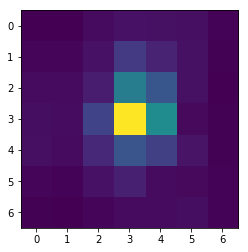

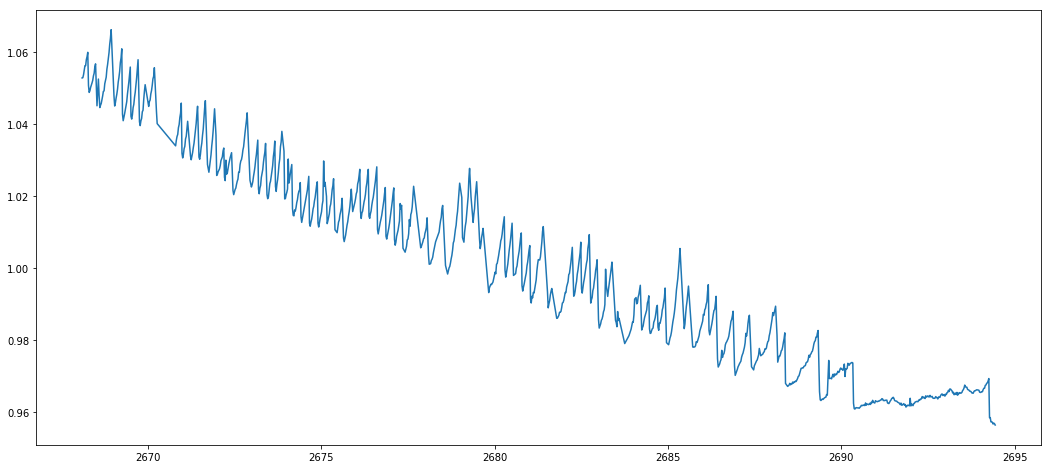

In [8]:
# Plot it
pl.imshow(np.nanmedian(target, axis=0), vmax=1e4)
target_lc = np.nansum(target, axis=(1, 2))
target_lc = target_lc / np.nanmedian(target_lc) - 1
target_lc = InterpolateOverFlags(target_lc, target_flags)
target_lc = InterpolateOverOutliers(target_lc, 2)
fig = pl.figure(figsize=(18, 8))
pl.plot(time, target_lc + 1);

In [13]:
# Label sources at 40 sigma and use them as regressors
lcs = []
lc_flags = []
for f, flg in tqdm(zip(flux, flags)):
    img = np.nanmedian(f, axis=0)
    mu = np.nanmedian(img)
    sigma = np.sqrt(np.nanmedian((img - mu) ** 2))
    m = (img - mu) > 40 * sigma
    m &= np.isfinite(img) 
    labels, nstar = label(m)
    if nstar > 0:
        for star in range(nstar):
            lcs.append(np.sum(f[:, labels == star + 1], axis=1))
            lc_flags.append(flg)

0it [00:00, ?it/s]/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
2545it [01:25, 29.79it/s]


In [12]:
# Normalize the regressors & remove outliers
lcs = lcs / np.median(lcs, axis=-1)[:, None] - 1
for i, lc in enumerate(lcs):
    lcs[i] = InterpolateOverFlags(lcs[i], lc_flags[i])
    lcs[i] = InterpolateOverOutliers(lcs[i], 2) 

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 3079 results
  r = func(a, **kwargs)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: On entry to DGELSD parameter number 6 had an illegal value

In [ ]:
len(lcs)

In [ ]:
def getMask(y, sigma=5, win=49):
    f = SavGol(y, win)
    med = np.nanmedian(f)
    MAD = 1.4826 * np.nanmedian(np.abs(f - med))
    mask = np.ones(len(time), dtype=bool)
    mask[np.where((f > med + sigma * MAD) | (f < med - sigma * MAD))] = 0
    return mask

In [ ]:
nlc = 2 * len(lcs)
T = tf.float32
np.random.seed(42)
lam_lc = 1e-1
lam_poly = 1e-5
npoly = 5

session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

y = tf.constant(target_lc, dtype=T)
X = np.hstack([lcs.T, lcs.T ** 2, np.vander(np.linspace(0, 1, len(time)), N=npoly, increasing=True)])

X = tf.constant(X, dtype=T)
mask = tf.constant(np.ones(len(time), dtype=bool), dtype=tf.bool)

# Initial (random) guess
A0 = X.eval()
w0 = np.random.randn(nlc + npoly)

lam_lc = tf.constant(lam_lc, dtype=T)
lam_poly = tf.constant(lam_poly, dtype=T)
w = tf.Variable(w0, dtype=T)

mod = tf.squeeze(tf.matmul(X, w[:, None]))

loss0 = tf.reduce_sum(tf.boolean_mask((y - mod)**2, mask))
loss1 = lam_lc * tf.reduce_sum(tf.abs(w[:nlc])) + lam_poly * tf.reduce_sum(w[nlc:] ** 2)
loss = loss0 + loss1

opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

XTX = tf.matmul(X, X, transpose_a=True)
XTy = tf.matmul(X, y[:, None], transpose_a=True)
bk = tf.reduce_sum(tf.abs(w[:nlc]))
wk = tf.squeeze(tf.linalg.solve(XTX + (lam_lc / bk + lam_poly) * tf.eye(nlc + npoly), XTy))

opt_ze = tf.assign(w, wk)

init = tf.global_variables_initializer()
session.run(init)

In [ ]:
def Detrend(outlier_mask, lambda_lc=5e-1, lambda_poly=1e-5):
    
    session.run(init)
    feed_dict = {mask: outlier_mask, lam_lc: lambda_lc, lam_poly: lambda_poly}

    # Fancy loss
    losses_fancy = np.zeros(1000)
    old_loss = loss.eval()
    old_w = w.eval()
    for i in range(len(losses_fancy)):
        session.run(opt_ze, feed_dict=feed_dict)
        new_loss = loss.eval()
        losses_fancy[i] = new_loss
        if new_loss > old_loss:
            fd = dict(feed_dict)
            fd[wk] = old_w
            session.run(opt_ze, feed_dict=fd)
            break
        old_loss = new_loss
        old_w = w.eval()

    print("Took %d Zé steps." % i)
    
    # Numerical loss
    '''
    for j in range(i, len(losses_fancy)):
        session.run(opt, feed_dict=feed_dict)
        losses_fancy[j] = loss.eval()
    '''
    
    # Show losses
    fig = pl.figure()
    pl.plot(losses_fancy, alpha=0.5)
    pl.yscale("log")

    # Show weights
    fig = pl.figure()
    pl.plot(w.eval()[:nlc]);

    # Show weights
    fig = pl.figure()
    pl.plot(w.eval()[nlc:]);

    # Show model and data
    fig = pl.figure(figsize=(14, 4))
    pl.plot(1 + y.eval());
    pl.plot(1 + mod.eval());

    # Show de-trended
    fig = pl.figure(figsize=(14, 4))
    pl.plot(1 + y.eval() - mod.eval());

In [ ]:
outlier_mask = np.ones(len(time), dtype=bool)
Detrend(outlier_mask, lambda_lc=1)